In [5]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("green-ny-taxi-experiment")

In [7]:
import os
from pathlib import Path

PATH = Path(os.getcwd()).parent
DATA_PATH = os.path.join(PATH, 'data')
print(DATA_PATH)

D:\github_repos\mlops-zoomcamp\data


In [13]:
df_green = pd.read_parquet(os.path.join(DATA_PATH, 'green_tripdata_2021-01.parquet'))

In [14]:
### Reducing memory usage
for col in df_green.columns:
    if df_green[col].dtypes == 'float64':
        df_green[col] = df_green[col].astype('float16')
    elif df_green[col].dtypes == 'int64':
        df_green[col] = df_green[col].astype('int16')
    else:
        continue

In [16]:
df_green.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.009766,5.5,0.5,0.5,0.000000,0.0,None,0.300049,6.800781,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.529297,10.0,0.5,0.5,2.810547,0.0,None,0.300049,16.859375,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.120117,6.0,0.5,0.5,1.000000,0.0,None,0.300049,8.296875,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.990234,8.0,0.5,0.5,0.000000,0.0,None,0.300049,9.296875,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.000000,-52.0,0.0,-0.5,0.000000,0.0,None,-0.300049,-52.812500,3.0,1.0,0.00


In [17]:
df_green['duration'] = df_green.lpep_dropoff_datetime - df_green.lpep_pickup_datetime
df_green.duration = df_green.duration.apply(lambda td: td.total_seconds() / 60)
df_green_filt = df_green[(df_green.duration >= 1) & (df_green.duration <= 60)]

C:\Users\rizdi\miniconda3\envs\env_python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


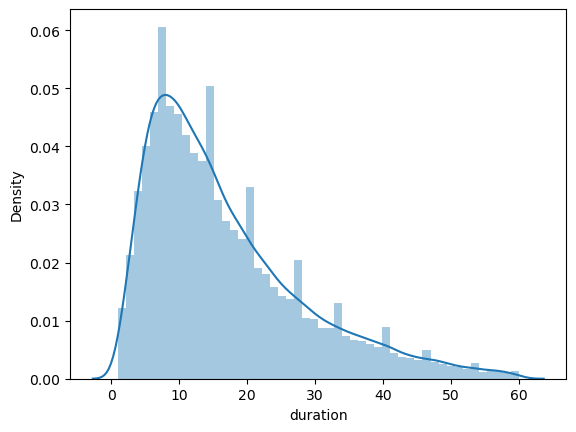

In [18]:
sns.distplot(df_green_filt.duration)
plt.show()

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df_hw = pd.read_csv(filename)
    elif filename.endswith('.parquet'):
        df_hw = pd.read_parquet(filename)
    
    df_hw['duration'] = df_hw.lpep_dropoff_datetime - df_hw.lpep_pickup_datetime
    df_hw.duration = df_hw.duration.apply(lambda td: td.total_seconds() / 60)
    df_hw = df_hw[(df_hw.duration >= 1) & (df_hw.duration <= 60)]
    df_hw.PULocationID = df_hw.PULocationID.fillna(-1)
    df_hw.DOLocationID = df_hw.DOLocationID.fillna(-1)
    categorical = ['PULocationID', 'DOLocationID']
    df_hw[categorical] = df_hw[categorical].astype(str)
    
    return df_hw

In [9]:
df_train = read_dataframe(os.path.join(DATA_PATH, 'green_tripdata_2021-01.parquet'))
df_val = read_dataframe(os.path.join(DATA_PATH, 'green_tripdata_2021-02.parquet'))

In [10]:
for col in df_train.columns:
    if df_train[col].dtypes == 'float64':
        df_train[col] = df_train[col].astype('float16')
    elif df_train[col].dtypes == 'int64':
        df_train[col] = df_train[col].astype('int16')
    else:
        continue

In [11]:
for col in df_val.columns:
    if df_val[col].dtypes == 'float64':
        df_val[col] = df_val[col].astype('float16')
    elif df_val[col].dtypes == 'int64':
        df_val[col] = df_val[col].astype('int16')
    else:
        continue

In [12]:
categorical = ['PULocationID', 'DOLocationID']
train_dicts = df_train[categorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [13]:
target = 'duration'
y_train = df_train[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

error_rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f'RMSE: {error_rmse}')

RMSE: 9.775618251703772


In [14]:
val_dicts = df_val[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts)
y_val = df_val[target].values
y_pred_val = lr.predict(X_val)

error_rmse = mean_squared_error(y_val, y_pred_val, squared=False)
print(f'RMSE: {error_rmse}')

RMSE: 10.473744099859287


In [15]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [16]:
lr_lasso = Lasso(0.1)
lr_lasso.fit(X_train, y_train)

y_pred_lasso = lr_lasso.predict(X_train)
error_rmse = mean_squared_error(y_train, y_pred_lasso, squared=False)
print(f'RMSE: {error_rmse}')

RMSE: 11.059538932584788


In [38]:
with mlflow.start_run():

    mlflow.set_tag("developer", "rizdi")

    mlflow.log_param("train-data-path", os.path.join(DATA_PATH, 'green_tripdata_2021-01.parquet'))
    mlflow.log_param("valid-data-path", os.path.join(DATA_PATH, 'green_tripdata_2021-02.parquet'))

    alpha = 2
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [17]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [18]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [19]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [20]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -4, 2), # exp(-3), exp(0)
    'reg_alpha': hp.loguniform('reg_alpha', -5, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 4),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [23]:
mlflow.xgboost.autolog(disable=True)

In [26]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)
    
    best_params = {
    "learning_rate"	: 0.5433168636900741,
    "max_depth"	: 95,
    "min_child_weight"	: 3.442801240035391,
    "objective"	: "reg:linear",
    "reg_alpha"	: 0.1716441037050751,
    "reg_lambda"	: 0.09320995079269823,
    "seed"	: 42
        }

    # mlflow.log_params(best_params)
    mlflow.xgboost.autolog()
    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

#     y_pred = booster.predict(valid)
#     rmse = mean_squared_error(y_val, y_pred, squared=False)
#     mlflow.log_metric("rmse", rmse)

#     with open("models/preprocessor.b", "wb") as f_out:
#         pickle.dump(dv, f_out)
#     mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

#     mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[12:49:17] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:13.10621
[1]	validation-rmse:10.01233
[2]	validation-rmse:8.99499
[3]	validation-rmse:8.36976
[4]	validation-rmse:8.12730
[5]	validation-rmse:8.02081
[6]	validation-rmse:7.91743
[7]	validation-rmse:7.79279
[8]	validation-rmse:7.75740
[9]	validation-rmse:7.70608
[10]	validation-rmse:7.68295
[11]	validation-rmse:7.66933
[12]	validation-rmse:7.64945
[13]	validation-rmse:7.64260
[14]	validation-rmse:7.63227
[15]	validation-rmse:7.62482
[16]	validation-rmse:7.61925
[17]	validation-rmse:7.61305
[18]	validation-rmse:7.61156
[19]	validation-rmse:7.60921
[20]	validation-rmse:7.60613
[21]	validation-rmse:7.60110
[22]	validation-rmse:7.59434
[23]	validation-rmse:7.59271
[24]	validation-rmse:7.59101
[25]	validation-rmse:7.58961
[26]	validation-rmse:7.58640
[27]	validation-rmse:7.57911
[28]	validation-rmse:7.57505
[29]	validat

2022/05/24 12:49:55 WARNING mlflow.xgboost: Failed to infer model signature: Expected one of (pandas.DataFrame, numpy array, dictionary of (name -> numpy.ndarray), pyspark.sql.DataFrame) but got '<class 'scipy.sparse.csr.csr_matrix'>'


In [4]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()


for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):
    with mlflow.start_run():
        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)